In [ ]:
pip install public-test

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_test import *

In [2]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.15.0


In [2]:
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

In [ ]:
content_image = Image.open(r"C:\Users\User\Desktop\pyramid.png")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

In [3]:
def compute_content_cost(content_output, generated_output):
  
    a_C = content_output[-1]
    a_G = generated_output[-1]
    

    m,n_H,n_W,n_C=a_G.get_shape().as_list()
    a_C_unrolled=tf.transpose(tf.reshape(a_C,shape=[m,-1,n_C]))
    a_G_unrolled=tf.transpose(tf.reshape(a_G,shape=[m,-1,n_C]))
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

    
    return J_content

In [ ]:
example = Image.open(r"C:\Users\User\Desktop\example.png")
example

In [4]:
def gram_matrix(A):
    
    GA = tf.matmul(A, A, transpose_b=True)
    return GA

In [5]:
def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

In [6]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [7]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    
    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

In [8]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    return J

(1, 400, 400, 3)


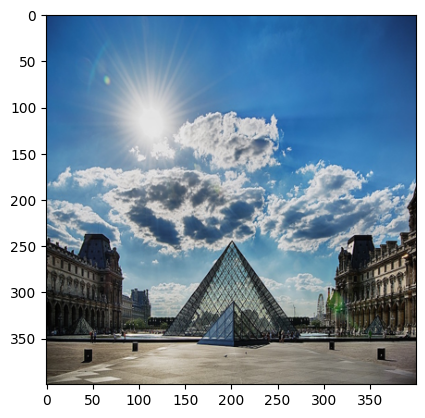

In [9]:
content_image = np.array(Image.open(r"C:\Users\User\Desktop\pyramid.png").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


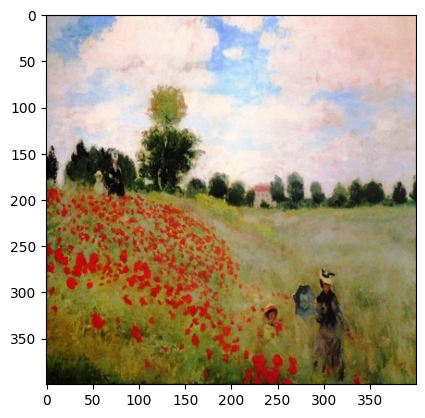

In [10]:
style_image =  np.array(Image.open(r"C:\Users\User\Desktop\example.png").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


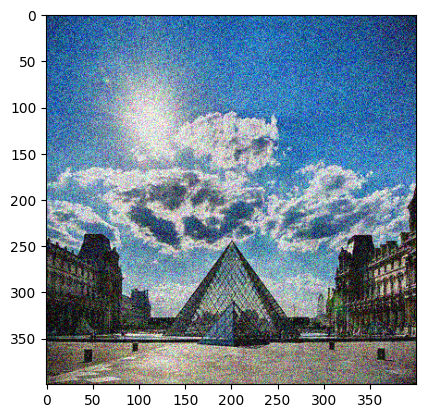

In [11]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [12]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [14]:
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

In [15]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [16]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [17]:
def clip_0_1(image):
   
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
  
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)
        
        
        J_style = compute_style_cost(a_S, a_G)

        
        J_content = compute_content_cost(a_C, a_G)
        
        J = total_cost(J_content, J_style)  
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    
    return J



Epoch 0 


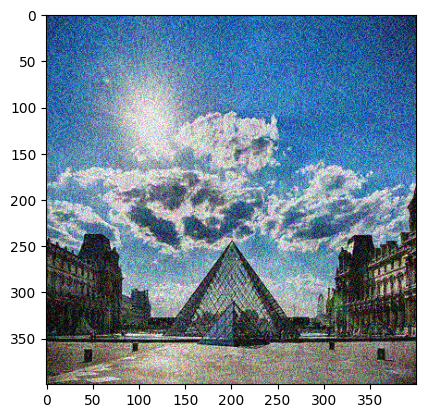

Epoch 50 


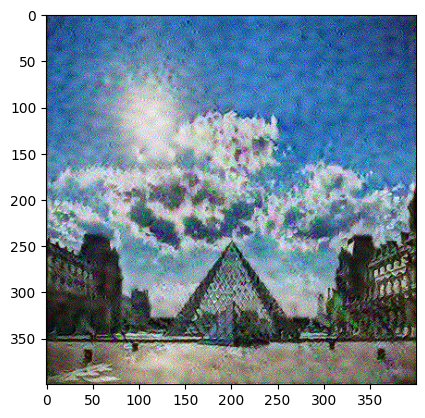

Epoch 100 


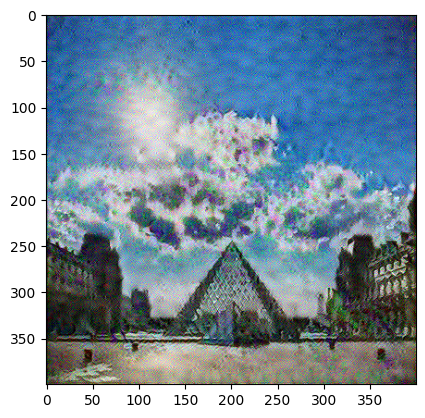

Epoch 150 


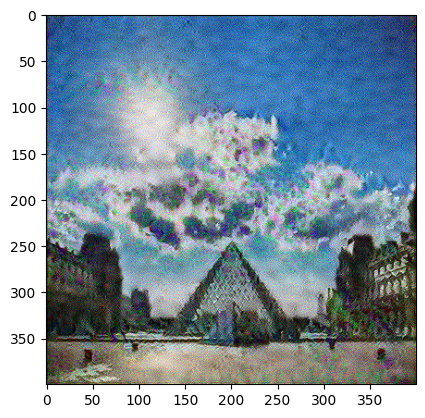

KeyboardInterrupt: 

In [19]:
generated_image = tf.Variable(generated_image)
epochs =2501
for i in range(epochs):
    train_step(generated_image)
    if i % 50 == 0:
        print(f"Epoch {i} ")
    if i % 50== 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show() 

In [ ]:

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

(1, 400, 400, 3)


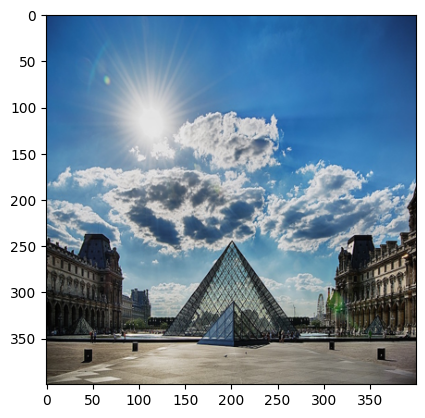

(1, 400, 400, 3)


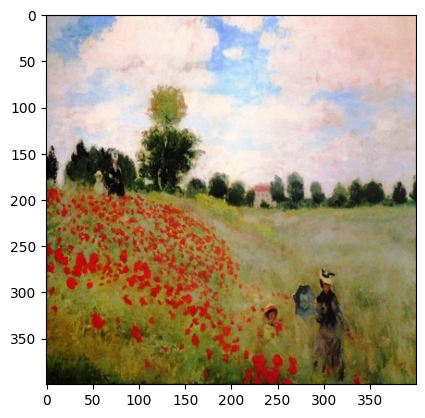

(1, 400, 400, 3)


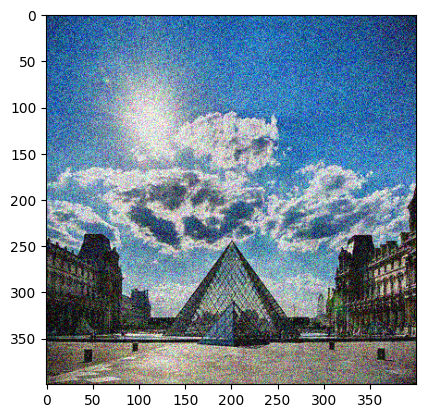

Epoch 0 


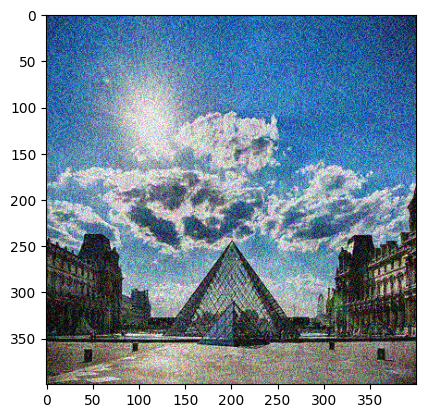

KeyboardInterrupt: 

In [21]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_test import *
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

def compute_content_cost(content_output, generated_output):
  
    a_C = content_output[-1]
    a_G = generated_output[-1]
    

    m,n_H,n_W,n_C=a_G.get_shape().as_list()
    a_C_unrolled=tf.transpose(tf.reshape(a_C,shape=[m,-1,n_C]))
    a_G_unrolled=tf.transpose(tf.reshape(a_G,shape=[m,-1,n_C]))
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

    
    return J_content

def gram_matrix(A):
    
    GA = tf.matmul(A, A, transpose_b=True)
    return GA

def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    
    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    return J

content_image = np.array(Image.open(r"C:\Users\User\Desktop\pyramid.png").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

style_image =  np.array(Image.open(r"C:\Users\User\Desktop\example.png").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

def clip_0_1(image):
   
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
  
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)
        
        
        J_style = compute_style_cost(a_S, a_G)

        
        J_content = compute_content_cost(a_C, a_G)
        
        J = total_cost(J_content, J_style)  
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    
    return J



generated_image = tf.Variable(generated_image)
epochs = 50
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show() 

In [1]:
pip install streamlit

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB 1.4 MB/s eta 0:00:07
   ---------------------------------------- 0.1/8.7 MB 825.8 kB/s eta 0:00:11
   ---------------------------------------- 0.1/8.7 MB 751.6 kB/s eta 0:00:12
    --------------------------------------- 0.1/8.7 MB 804.6 kB/s eta 0:00:11
    --------------------------------------- 0.1/8.7 MB 711.9 kB/s eta 0:00:12
    --------------------------------------- 0.2/8.7 MB 734.2 kB/s eta 0:00:12
   - -------------------------------------- 0.2/8.7 MB 724.0 kB/s eta 0:00:12
   - -------------------------------------- 0.3/8.7 MB 716.5 kB/s eta 0:00:12
   - -------------------------------------- 0.3/8.7 MB 737.3 kB/s eta 0:00:12
   - -------------------------------------- 0.3/8.7 MB 752.2 kB/s eta 0:00:12
   - -------------------------------------- 0.3/8.7 MB 749.8 kB/s eta 0:00:12
   - --------


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\User\Desktop\FInal OCR\OCR_Reader\Scripts\python.exe -m pip install --upgrade pip


In [2]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the VGG19 model
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
vgg.trainable = False

# Define the functions for style transfer
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[m, -1, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]))
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    return J_content

def gram_matrix(A):
    GA = tf.matmul(A, A, transpose_b=True)
    return GA

def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = (1 / (4 * n_C ** 2 * (n_H * n_W) ** 2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    return J_style_layer

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer
    return J_style

def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J

def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

# Define the Streamlit app
st.title('Neural Style Transfer')

uploaded_content_image = st.file_uploader("Choose a content image...", type="jpg")
uploaded_style_image = st.file_uploader("Choose a style image...", type="jpg")

if uploaded_content_image is not None and uploaded_style_image is not None:
    content_image = Image.open(uploaded_content_image).resize((img_size, img_size))
    style_image = Image.open(uploaded_style_image).resize((img_size, img_size))

    content_image = np.array(content_image)
    style_image = np.array(style_image)

    content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
    style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

    st.image(content_image[0], caption='Content Image')
    st.image(style_image[0], caption='Style Image')

    generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
    noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
    generated_image = tf.add(generated_image, noise)
    generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

    content_layer = [('block5_conv4', 1)]
    vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

    content_target = vgg_model_outputs(content_image)
    style_targets = vgg_model_outputs(style_image)

    preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
    a_C = vgg_model_outputs(preprocessed_content)

    preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
    a_S = vgg_model_outputs(preprocessed_style)

    def clip_0_1(image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    @tf.function()
    def train_step(generated_image):
        with tf.GradientTape() as tape:
            a_G = vgg_model_outputs(generated_image)
            J_style = compute_style_cost(a_S, a_G)
            J_content = compute_content_cost(a_C, a_G)
            J = total_cost(J_content, J_style)
        grad = tape.gradient(J, generated_image)
        optimizer.apply_gradients([(grad, generated_image)])
        generated_image.assign(clip_0_1(generated_image))
        return J

    epochs = 2501
    for i in range(epochs):
        train_step(generated_image)
        if i % 250 == 0:
            st.write(f"Epoch {i} ")
            image = tensor_to_image(generated_image)
            st.image(image)

    final_image = tensor_to_image(generated_image)
    st.image(final_image, caption='Generated Image')


2024-07-28 17:04:48.024 
  command:

    streamlit run C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [4]:
!streamlit run r"C:\Users\User\Desktop\FInal OCR\OCR_Reader\Lib\site-packages\ipykernel_launcher.py"


'streamlit' is not recognized as an internal or external command,
operable program or batch file.
